__Author:__ Bram Van de Sande

__Date:__ 11 FEB 2018

__Outline:__ Compare the results of the different implementation of the SCENIC pipeline. The example used in the tutorial is used in this comparison (https://github.com/aertslab/SCENIC). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyscenic.utils import save_to_yaml
%matplotlib inline

### Phase Ib: Derive potential regulomes from these co-expression modules

#### Check implementation of `modules_from_genie3`

Start from the GENIE3 output and check if derived co-expression modules are similar.

In [2]:
adjacencies = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.5_GENIE3_linkList.txt',
                          usecols=['TF', 'Target', 'weight'])
adjacencies.columns = ["TF", "target", "importance"]

Creation of the modules.

In [5]:
df_modules = adjacencies[adjacencies['importance'] > 0.001]
df_modules['method'] = 'w001'

df_tmp = adjacencies[adjacencies['importance'] > 0.005].copy()
df_tmp['method'] = 'w005'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='TF').apply(lambda grp: grp.nlargest(50, "importance")).copy()
df_tmp['method'] = 'top50'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(5, "importance")).copy()
df_tmp['method'] = 'top5perTarget'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(10, "importance")).copy()
df_tmp['method'] = 'top10perTarget'
df_modules = df_modules.append(df_tmp)

df_tmp = adjacencies.groupby(by='target').apply(lambda grp: grp.nlargest(50, "importance")).copy()
df_tmp['method'] = 'top50perTarget'
df_modules = df_modules.append(df_tmp)
df_modules.index = range(len(df_modules))

In [6]:
len(df_modules)

4363616

In [7]:
df_modules.method.value_counts()

w001              3261351
top50perTarget     604300
w005               266475
top10perTarget     120860
top5perTarget       60430
top50               50200
Name: method, dtype: int64

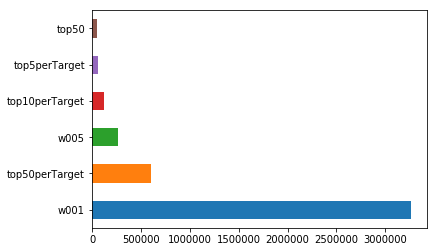

In [8]:
df_modules.method.value_counts().plot.barh()

In [9]:
df_modules[df_modules['TF'] == df_modules['target']]

,TF,target,importance,method


Compare the results with the modules derived by the R pipeline.

In [10]:
r_modules = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.6_tfModules.txt',
                          usecols=['Target', 'TF', 'method'])
r_modules.columns = ['target', 'TF', 'method']

In [12]:
len(r_modules)

4363616

In [13]:
r_modules.method.value_counts()

w001              3261351
top50perTarget     604300
w005               266475
top10perTarget     120860
top5perTarget       60430
top50               50200
Name: method, dtype: int64

Exact comparison.

In [14]:
COLUMN_NAMES = ['TF', 'target', 'method']
df_modules = df_modules[COLUMN_NAMES].sort_values(by=COLUMN_NAMES).reset_index()
del df_modules['index']

In [15]:
r_modules = r_modules.sort_values(by=COLUMN_NAMES).reset_index()
del r_modules['index']
r_modules = r_modules[COLUMN_NAMES]

In [16]:
r_modules.equals(df_modules)

True

### Phase II: Prune modules for targets with cis regulatory footprints (aka RcisTarget)

Testing of RcisTarget should start from exactly the same baseline. Modules for the python pipeline will therefore be created from the link lists with correlation information used in the R scripts.

In [3]:
from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
import os
from collections import defaultdict
from pyscenic.genesig import Regulome
from operator import concat
from functools import reduce
from pyscenic.regulome import derive_regulomes

In [4]:
DATABASE_FOLDER = "/Users/bramvandesande/Projects/lcb/databases/"
DATABASE_FNAME_500bp = os.path.join(DATABASE_FOLDER, "mm9-500bp-upstream-10species.mc8nr.feather")
DATABASE_FNAME_10kbp = os.path.join(DATABASE_FOLDER, "mm9-tss-centered-10kb-10species.mc8nr.feather")

RESOURCES_FOLDER="/Users/bramvandesande/Projects/lcb/resources"
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")

#### Create modules from R datafile

In [5]:
r_adjacencies = pd.read_csv('/Users/bramvandesande/Projects/lcb/resources/rscenic/1.7_tfModules_withCorr.txt',
                         usecols=['Target', 'TF', 'method', 'corr'])
r_adjacencies.head()

,Target,TF,method,corr
0,Slc27a3,1810024B03Rik,w001,0
1,Ankrd39,1810024B03Rik,w001,1
2,Tbc1d25,1810024B03Rik,w001,0
3,Mak,1810024B03Rik,w001,1
4,Tmem86b,1810024B03Rik,w001,1


1. Remove genes in a module that are not part of the database rankings.
2. Remove modules with number of genes < 20.
3. Add own TF to its own module.
4. Only look at TF-target that have an activiting function.

In [6]:
genes_in_db = RankingDatabase(DATABASE_FNAME_500bp, name="500bp", nomenclature="MGI").geneset
r_adjacencies = r_adjacencies[r_adjacencies['corr'] > 0]
method2modules = defaultdict(list)
for (tf, method), df_grp in r_adjacencies.groupby(by=['TF', 'method']):
    targets = set(df_grp['Target'].values)
    if len(targets) < 20:
        continue
    targets.add(tf)
    regulome = Regulome(name="{} - {}".format(tf, method), nomenclature="MGI", 
                        score=0.0, context=frozenset([method]),
                        transcription_factor=tf, gene2weights=targets.intersection(genes_in_db))
    method2modules[method].append(regulome)

In [7]:
for method, modules in method2modules.items():
    print(method, "-", len(modules))

top50 - 974
top50perTarget - 976
w001 - 1004
w005 - 612
top10perTarget - 486
top5perTarget - 259


In [8]:
modules = reduce(concat, method2modules.values())
len(modules)

4311

In [8]:
save_to_yaml(modules, os.path.join(RESOURCES_FOLDER, "modules_zeisel_2015.yaml"))

#### Create dataframe with enriched and TF-annotated motifs + leading edges

In [9]:
rnkdbs = [RankingDatabase(fname, name, "MGI") for fname, name in zip([DATABASE_FNAME_500bp, DATABASE_FNAME_10kbp], ['500bp', '10kbp'])]
rnkdbs

[FeatherRankingDatabase(name="500bp",nomenclature=MGI),
 FeatherRankingDatabase(name="10kbp",nomenclature=MGI)]

In [10]:
df = derive_regulomes(rnkdbs, modules, 
                      MOTIF_ANNOTATIONS_FNAME, 
                      rank_threshold=5000, auc_threshold=0.01, nes_threshold=3.0,
                      output="df",
                      client_or_address="custom_multiprocessing", num_workers=6)

Using 6 workers.
2018-02-11 16:56:54.398657 - Worker 500bp(2): database loaded in memory.
2018-02-11 16:56:54.409113 - Worker 500bp(3): database loaded in memory.
2018-02-11 16:56:54.409830 - Worker 500bp(1): database loaded in memory.
2018-02-11 16:56:55.583456 - Worker 500bp(1): motif annotations loaded in memory.
2018-02-11 16:56:55.588399 - Worker 500bp(3): motif annotations loaded in memory.
2018-02-11 16:56:55.588453 - Worker 500bp(2): motif annotations loaded in memory.
2018-02-11 16:57:03.008167 - Worker 10kbp(3): database loaded in memory.
2018-02-11 16:57:03.032114 - Worker 10kbp(2): database loaded in memory.
2018-02-11 16:57:03.032861 - Worker 10kbp(1): database loaded in memory.
2018-02-11 16:57:04.672461 - Worker 10kbp(3): motif annotations loaded in memory.
2018-02-11 16:57:04.692973 - Worker 10kbp(2): motif annotations loaded in memory.
2018-02-11 16:57:04.701290 - Worker 10kbp(1): motif annotations loaded in memory.
2018-02-11 18:50:07.444854 - Worker 500bp(3): All reg

Potential causes of differences:
1. 0-based rankings (python) versus 1-based rankings (R SCENIC version)? This has an effect on the interpretation of rank_cutoff. With 0-based the rank_cutoff is included while in 1-based systems this is not the cause. Both are correct calculations but just a difference in interpretation of the parameter. The normalization factor (maxAUC) should be corrected though.
```
aucThreshold <- round(aucMaxRank)
maxAUC <- aucThreshold * nrow(gSetRanks)
```
(According to this code snippet the maxAUC is calculated to take the aucThreshold into account while this is not the case for the current R implementation of the AUC calculation + 1-based rankings)
```
.auc <- function(oneRanking, aucThreshold, maxAUC)
{
  x <- oneRanking
  x <- sort(x[x<aucThreshold])

  y <- seq_along(x)
  sum(diff(c(x, aucThreshold)) * y)/maxAUC
}
```
2. NES threshold (3.0). Exactly the same for both pipeline.
3. Digits for truncation of NES and AUC values (3). Is available in the R version of the pipeline. This should have no effect on the calculations as this is only used for creating the final results table.
4. Rank threshold (5000). Is exactly the same. Can only have an effect on the LE calculation. Has no effect on AUC calculations.
5. AUC fraction (0.01). Is used to calculate the rank cutoff. Is the same between both pipelines.
6. Minimum orthologous identity and maximum motif similarity FDR: effect can be assessed in the results table from the python pipeline.
7. Are we sure we use exactly the same ranking databases? In the tutorial 20k features are used. The database used for this exercise also has 20k features.

In [11]:
len(df)

13527

In [12]:
df.head()

Enrichment            \
                                            AUC       NES   
TF     MotifID                                              
Acaa1b transfac_pro__M01543            0.076742  4.867355   
       transfac_pro__M04671            0.076380  4.841798   
Ar     homer__CCAGGAACAG_AR-halfsite   0.050721  7.579484   
Arid3a transfac_pro__M04727            0.033484  3.125181   
       cisbp__M4455                    0.035068  3.301812   

                                                            \
                                     MotifSimilarityQvalue   
TF     MotifID                                               
Acaa1b transfac_pro__M01543                       0.000000   
       transfac_pro__M04671                       0.000000   
Ar     homer__CCAGGAACAG_AR-halfsite              0.000000   
Arid3a transfac_pro__M04727                       0.000255   
       cisbp__M4455                               0.000009   

                                                          \
                                     OrthologousIdentity   
TF     MotifID                                             
Acaa1b transfac_pro__M01543                     0.517986   
       transfac_pro__M04671                     0.517986   
Ar     homer__CCAGGAACAG_AR-halfsite            0.877642   
Arid3a transfac_pro__M04727                     0.798669   
       cisbp__M4455                             0.798669   

                                                                                         \
                                                                             Annotation   
TF     MotifID                                                                            
Acaa1b transfac_pro__M01543           motif similar to transfac_pro__M04671 ('F$POT1...   
       transfac_pro__M04671           motif is annotated for orthologous gene YIL160...   
Ar     homer__CCAGGAACAG_AR-halfsite  gene is orthologous to ENSG00000169083 in H. s...   
Arid3a transfac_pro__M04727           gene is orthologous to ENSG00000116017 in H. s...   
       cisbp__M4455                   gene is orthologous to ENSG00000116017 in H. s...   

                                                      \
                                             Context   
TF     MotifID                                         
Acaa1b transfac_pro__M01543           (top50, 500bp)   
       transfac_pro__M04671           (top50, 500bp)   
Ar     homer__CCAGGAACAG_AR-halfsite  (top50, 500bp)   
Arid3a transfac_pro__M04727           (top50, 500bp)   
       cisbp__M4455                   (top50, 500bp)   

                                                                                         
                                                                            TargetGenes  
TF     MotifID                                                                           
Acaa1b transfac_pro__M01543           [(Col7a1, 1.0), (Lmna, 1.0), (Crh, 1.0), (Htr1...  
       transfac_pro__M04671           [(Col7a1, 1.0), (Lmna, 1.0), (Crh, 1.0), (Htr1...  
Ar     homer__CCAGGAACAG_AR-halfsite        [(Bmpr1b, 1.0), (Kcns1, 1.0), (Ptpru, 1.0)]  
Arid3a transfac_pro__M04727                                               [(Sdk2, 1.0)]  
       cisbp__M4455                                    [(Hbegf, 1.0), (Tnfaip8l2, 1.0)]

There are far less regulomes when using the python pipeline.

In [13]:
df.index.get_level_values('TF').unique()

Index(['Acaa1b', 'Ar', 'Arid3a', 'Arid5b', 'Arx', 'Ascl1', 'Atf1', 'Atf2',
       'Atf3', 'Atf4',
       ...
       'Sox12', 'Tia1', 'Zfp148', 'Gli3', 'Grhl1', 'Meis2', 'Olig2', 'Zfhx2',
       'Zfp672', 'Zfp467'],
      dtype='object', name='TF', length=399)

In [14]:
df.index.get_level_values('TF').unique().values

array(['Acaa1b', 'Ar', 'Arid3a', 'Arid5b', 'Arx', 'Ascl1', 'Atf1', 'Atf2',
       'Atf3', 'Atf4', 'Atf5', 'Atf6', 'Bbx', 'Bhlhe22', 'Cbfb', 'Ccnt2',
       'Cebpb', 'Cebpg', 'Cic', 'Ckmt1', 'Clock', 'Cpsf4', 'Creb1',
       'Creb3', 'Creb3l1', 'Crebl2', 'Ctcf', 'Dbx2', 'Dlx1', 'Dlx2',
       'Dlx5', 'Dmrta2', 'E2f1', 'E2f3', 'E2f4', 'E2f5', 'E2f6', 'E4f1',
       'Egr4', 'Elf1', 'Elk3', 'Elk4', 'Emx1', 'Ep300', 'Ets1', 'Ets2',
       'Etv3', 'Etv4', 'Fli1', 'Fos', 'Fosb', 'Fosl2', 'Foxj3', 'Foxk1',
       'Foxo1', 'Foxp1', 'Foxp2', 'Gabpb1', 'Gata2', 'Gtf2b', 'Hif1a',
       'Hivep3', 'Homez', 'Hsf1', 'Irf2', 'Irf3', 'Irf9', 'Jdp2', 'Jun',
       'Junb', 'Jund', 'Kdm5a', 'Klf16', 'Klf2', 'Lhx6', 'Maf', 'Mef2a',
       'Mxd4', 'Myc', 'Neurod1', 'Nfe2l1', 'Nfe2l2', 'Nfib', 'Nfic',
       'Nkx2-2', 'Nr1d1', 'Nr1d2', 'Nr2c1', 'Nr2e1', 'Nr2f1', 'Nr2f2',
       'Nr2f6', 'Nr3c1', 'Nr6a1', 'Patz1', 'Pbx3', 'Pbx4', 'Pck2', 'Phf8',
       'Pole3', 'Polr3g', 'Pou2f1', 'Pou3f2', 'Pou3f4', 'Ppard',

Compare the top 5 results documented in the tutorial.

In [15]:
df[df.index.get_level_values('TF') == 'Rfx3'].sort_values(by=('Enrichment', 'NES'), ascending=False)

Enrichment            \
                                                    AUC       NES   
TF   MotifID                                                        
Rfx3 cisbp__M1524                              0.100987  9.658617   
     cisbp__M1533                              0.092349  8.776800   
     cisbp__M1539                              0.092349  8.776800   
     cisbp__M1528                              0.090498  8.587839   
     cisbp__M1524                              0.113414  8.382514   
     cisbp__M1525                              0.088235  8.356887   
     cisbp__M1529                              0.085253  8.052451   
     cisbp__M1537                              0.097796  7.833938   
     cisbp__M1536                              0.082991  7.821499   
     cisbp__M1537                              0.082991  7.821499   
     cisbp__M1524                              0.095898  7.671349   
     cisbp__M1529                              0.095752  7.658842   
     cisbp__M1533                              0.101445  7.434598   
     cisbp__M1539                              0.101445  7.434598   
     cisbp__M1535                              0.092687  7.396198   
     cisbp__M1528                              0.098672  7.214959   
     cisbp__M1534                              0.076923  7.202127   
     cisbp__M1530                              0.090060  7.171075   
     yetfasco__YLR176C_496                     0.076512  7.160136   
     cisbp__M1525                              0.095606  6.972200   
     cisbp__M1537                              0.068902  6.953047   
     hdpi__RFX3                                0.073632  6.866197   
     transfac_pro__M02789                      0.073221  6.824206   
     cisbp__M1524                              0.067565  6.806619   
     cisbp__M1528                              0.085681  6.795869   
     cisbp__M1539                              0.085681  6.795869   
     cisbp__M1529                              0.067462  6.795355   
     cisbp__M1534                              0.014646  6.786273   
     cisbp__M1532                              0.085535  6.783362   
     cisbp__M1524                              0.076237  6.738998   
...                                                 ...       ...   
     cisbp__M1528                              0.019666  3.243580   
     cisbp__M2309                              0.034862  3.224760   
     transfac_pro__M07305                      0.011548  3.206031   
     cisbp__M1530                              0.017287  3.196852   
     cisbp__M1524                              0.017287  3.196852   
     transfac_pro__M07123                      0.039079  3.190720   
     scertf__macisaac.RFX1                     0.038941  3.177626   
     cisbp__M1539                              0.019337  3.165574   
     cisbp__M2309                              0.038804  3.164533   
     cisbp__M5780                              0.038804  3.164533   
     cisbp__M5775                              0.038667  3.151440   
     cisbp__M6451                              0.017113  3.150325   
     cisbp__M6077                              0.047292  3.145857   
     cisbp__M1529                              0.017017  3.124477   
     transfac_pro__M07882                      0.011416  3.123059   
     cisbp__M6451                              0.047000  3.122737   
     cisbp__M4575                              0.010186  3.119443   
     taipale__RFX2_DBD_NGTTRCCATGGYAACN_repr   0.038256  3.112160   
     cisbp__M6452                              0.010164  3.101402   
     cisbp__M1535                              0.037982  3.085973   
     yetfasco__YLR176C_496                     0.034828  3.082748   
     cisbp__M1525                              0.016804  3.067611   
     transfac_pro__M04759                      0.011327  3.066592   
     transfac_pro__M04759                      0.046271  3.064937   
     transfac_pro__M07880                  

Save to disk.

In [16]:
df.to_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"))

In [18]:
#df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "regulomes_zeisel_2015.csv"),
#                 index_col=[0,1], header=[0,1], skipinitialspace=True)

Compare enriched motifs with results from R pipeline.

In [19]:
r_df = pd.read_csv(os.path.join(RESOURCES_FOLDER, "rscenic/2.4_motifEnrichment_selfMotifs.txt"))

In [26]:
r_df.sort_values(by='NES', ascending=False).sort_values(by=['highlightedTFs']).head(15)

,Unnamed: 0,motifDb,geneSet,motif,NES,AUC,highlightedTFs,TFinDB,TF_direct,TF_inferred
1,2,500bp,Acaa1b_top50,transfac_pro__M04671,4.28,0.0733,Acaa1b,**,Acaa1a; Acaa1b; Foxf1; Foxf2; Foxg1; Foxh1; Fo...,NaN
0,1,500bp,Acaa1b_top50,transfac_pro__M01543,4.39,0.0749,Acaa1b,**,Acaa1a; Acaa1b; Foxf1; Foxf2; Foxg1; Foxh1; Fo...,NaN
2,3,500bp,Ahr_w001,transfac_pro__M00778,3.22,0.0131,Ahr,**,Ahr,NaN
4,5,500bp,Ahr_w001,cisbp__M6139,3.08,0.0128,Ahr,**,Ahr,Arnt
5,6,500bp,Ahr_w001,transfac_pro__M00976,3.03,0.0127,Ahr,**,Ahr; Ahrr; Arnt; Arnt2; Hif1a,NaN
3,4,500bp,Ahr_w001,hocomoco__AHR_HUMAN.H10MO.B,3.12,0.0129,Ahr,**,Ahr,Arnt
6,7,500bp,Anxa11_top50,hdpi__ANXA11,3.15,0.0478,Anxa11,**,Anxa11,NaN
46,47,500bp,Ar_top50,homer__CCAGGAACAG_AR-halfsite,7.21,0.0537,Ar,**,Ar,NaN
5037,5038,10kbp,Ar_top50,cisbp__M5683,3.12,0.0322,Ar,**,Ar; Nr3c1; Nr3c2,NaN
5017,5018,10kbp,Arid3a_w001,tfdimers__MD00454,3.10,0.0151,Arid3a,**,Arid3a; Pax4,NaN


In [21]:
df.head().sort_values(by=[('Enrichment', 'NES')], ascending=False).sort_index(level=0).head(10)

Enrichment            \
                                            AUC       NES   
TF     MotifID                                              
Acaa1b transfac_pro__M01543            0.076742  4.867355   
       transfac_pro__M04671            0.076380  4.841798   
Ar     homer__CCAGGAACAG_AR-halfsite   0.050721  7.579484   
Arid3a cisbp__M4455                    0.035068  3.301812   
       transfac_pro__M04727            0.033484  3.125181   

                                                            \
                                     MotifSimilarityQvalue   
TF     MotifID                                               
Acaa1b transfac_pro__M01543                       0.000000   
       transfac_pro__M04671                       0.000000   
Ar     homer__CCAGGAACAG_AR-halfsite              0.000000   
Arid3a cisbp__M4455                               0.000009   
       transfac_pro__M04727                       0.000255   

                                                          \
                                     OrthologousIdentity   
TF     MotifID                                             
Acaa1b transfac_pro__M01543                     0.517986   
       transfac_pro__M04671                     0.517986   
Ar     homer__CCAGGAACAG_AR-halfsite            0.877642   
Arid3a cisbp__M4455                             0.798669   
       transfac_pro__M04727                     0.798669   

                                                                                         \
                                                                             Annotation   
TF     MotifID                                                                            
Acaa1b transfac_pro__M01543           motif similar to transfac_pro__M04671 ('F$POT1...   
       transfac_pro__M04671           motif is annotated for orthologous gene YIL160...   
Ar     homer__CCAGGAACAG_AR-halfsite  gene is orthologous to ENSG00000169083 in H. s...   
Arid3a cisbp__M4455                   gene is orthologous to ENSG00000116017 in H. s...   
       transfac_pro__M04727           gene is orthologous to ENSG00000116017 in H. s...   

                                                      \
                                             Context   
TF     MotifID                                         
Acaa1b transfac_pro__M01543           (top50, 500bp)   
       transfac_pro__M04671           (top50, 500bp)   
Ar     homer__CCAGGAACAG_AR-halfsite  (top50, 500bp)   
Arid3a cisbp__M4455                   (top50, 500bp)   
       transfac_pro__M04727           (top50, 500bp)   

                                                                                         
                                                                            TargetGenes  
TF     MotifID                                                                           
Acaa1b transfac_pro__M01543           [(Col7a1, 1.0), (Lmna, 1.0), (Crh, 1.0), (Htr1...  
       transfac_pro__M04671           [(Col7a1, 1.0), (Lmna, 1.0), (Crh, 1.0), (Htr1...  
Ar     homer__CCAGGAACAG_AR-halfsite        [(Bmpr1b, 1.0), (Kcns1, 1.0), (Ptpru, 1.0)]  
Arid3a cisbp__M4455                                    [(Hbegf, 1.0), (Tnfaip8l2, 1.0)]  
       transfac_pro__M04727                                               [(Sdk2, 1.0)]

#### Creation of regulomes

In [22]:
from pyscenic.regulome import df2regulomes

In [23]:
regulomes = df2regulomes(df, "MGI")

In [24]:
len(regulomes)

399

In [25]:
regulomes[0:3]

[Regulome(name='Acaa1b', nomenclature='MGI', gene2weights=<frozendict {'Col7a1': 1.0, 'Lmna': 1.0, 'Crh': 1.0, 'Htr1f': 1.0, 'Rilpl2': 1.0, 'Phf21b': 1.0, 'Poli': 1.0, 'Mtfr1': 1.0}>, transcription_factor='Acaa1b', context=frozenset(), score=2.5212217345523453),
 Regulome(name='Ahr', nomenclature='MGI', gene2weights=<frozendict {'Crh': 1.0, 'Smad3': 1.0, 'Usp28': 1.0, 'Zbtb25': 1.0, 'Samd12': 1.0, 'Bhlhe41': 1.0, 'Maf': 1.0, 'Pou2f1': 1.0, 'St5': 1.0, 'Lin28b': 1.0, 'Maml3': 1.0, 'Zswim5': 1.0, 'Islr2': 1.0, 'Smoc2': 1.0, 'BC048403': 1.0, 'Slc25a36': 1.0, 'Erlin2': 1.0, 'Mir682': 1.0, 'Arrb2': 1.0, 'Aatf': 1.0, 'Apaf1': 1.0, 'Adrb2': 1.0, 'Dll3': 1.0, 'Kdm2b': 1.0, 'Tfdp2': 1.0, 'Nr4a2': 1.0, 'Phip': 1.0, 'Klf6': 1.0, 'Gjd2': 1.0, 'Dag1': 1.0, 'Igf2bp3': 1.0, '1190002N15Rik': 1.0, 'Gm129': 1.0, 'Kdm6a': 1.0, 'Slco5a1': 1.0, 'Atxn3': 1.0, 'Vps33a': 1.0, 'Nab2': 1.0, 'Senp8': 1.0, 'Tug1': 1.0, 'Gt(ROSA)26Sor': 1.0, 'Kat5': 1.0, 'Ncoa5': 1.0, 'Sirt1': 1.0, 'Ero1l': 1.0, 'Pdcd6ip': 1.0, 'K